# Feature Engineering, Feature / Permutation Importance, Pruning

## Setup

In [14]:
import pandas as pd
import numpy as np
import time, os, sys, warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import catboost as cat 
import lightgbm as lgb 

from src.config import PROJECT_PATH, DATA_PATH, USE_WANDB, WANDB_PROJECT, WANDB_ENTITY
from src.tracking import ExperimentTracker
from src.training import train_and_evaluate_model, average_f1_score
from src.feature_engineering import create_wave2_features, create_wave3_features, create_wave4_features

SEED = 42

In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 10000):
        display(df)

In [3]:
# Initialize the experiment tracker
tracker = ExperimentTracker(
    project_path=PROJECT_PATH,
    use_wandb=USE_WANDB,
    wandb_project_name=WANDB_PROJECT,
    wandb_entity=WANDB_ENTITY
)

In [4]:
# Load full training data, gesture mappings and inverse gesture mappings
#df_train = pd.read_feather('processed_data/train_full.feather')
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_demographics = pd.read_csv(os.path.join(DATA_PATH, 'train_demographics.csv'))

with open('processed_data/gesture_mappings.pkl', 'rb') as f:
    gesture_to_seq_type_map, gesture_map, inv_gesture_map = pickle.load(f)

In [5]:
display_all(df_train.head(2))

row_id sequence_type sequence_id  sequence_counter      subject  \
0  SEQ_000007_000000        Target  SEQ_000007                 0  SUBJ_059520   
1  SEQ_000007_000001        Target  SEQ_000007                 1  SUBJ_059520   

                       orientation                                   behavior  \
0  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
1  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   

        phase             gesture     acc_x     acc_y     acc_z     rot_w  \
0  Transition  Cheek - pinch skin  6.683594  6.214844  3.355469  0.134399   
1  Transition  Cheek - pinch skin  6.949219  6.214844  3.125000  0.143494   

      rot_x     rot_y     rot_z      thm_1      thm_2      thm_3      thm_4  \
0 -0.355164 -0.447327 -0.809753  28.943842  31.822186  29.553024  28.592863   
1 -0.340271 -0.428650 -0.824524  29.340816  31.874645  29.791740  28.663383   

       thm_5  tof_1_v0  tof_1_v1  tof_1_v2  tof_1_v3  tof_1_v4  tof_1_v5  \
0  28.310535     131.0     134.0     132.0     135.0      98.0      74.0   
1  28.406172     130.0     138.0     131.0     135.0     101.0      76.0   

   tof_1_v6  tof_1_v7  tof_1_v8  tof_1_v9  tof_1_v10  tof_1_v11  tof_1_v12  \
0      64.0      60.0      -1.0      -1.0      152.0      153.0      141.0   
1      66.0      61.0      -1.0      -1.0      156.0      155.0      141.0   

   tof_1_v13  tof_1_v14  tof_1_v15  tof_1_v16  tof_1_v17  tof_1_v18  \
0       89.0       68.0       63.0       -1.0       -1.0       -1.0   
1       93.0       74.0       64.0       -1.0       -1.0       -1.0   

   tof_1_v19  tof_1_v20  tof_1_v21  tof_1_v22  tof_1_v23  tof_1_v24  \
0       -1.0      169.0      118.0       86.0       73.0       -1.0   
1       -1.0      165.0      116.0       86.0       75.0      130.0   

   tof_1_v25  tof_1_v26  tof_1_v27  tof_1_v28  tof_1_v29  tof_1_v30  \
0       -1.0       -1.0       -1.0       -1.0      147.0      110.0   
1       -1.0       -1.0       -1.0       -1.0      142.0      114.0   

   tof_1_v31  tof_1_v32  tof_1_v33  tof_1_v34  tof_1_v35  tof_1_v36  \
0       87.0      126.0       -1.0       -1.0       -1.0       -1.0   
1       91.0      127.0       -1.0       -1.0       -1.0       -1.0   

   tof_1_v37  tof_1_v38  tof_1_v39  tof_1_v40  tof_1_v41  tof_1_v42  \
0       -1.0      137.0      108.0      115.0       -1.0       -1.0   
1       -1.0      145.0      114.0      114.0       -1.0       -1.0   

   tof_1_v43  tof_1_v44  tof_1_v45  tof_1_v46  tof_1_v47  tof_1_v48  \
0       -1.0       -1.0       -1.0       -1.0      128.0      110.0   
1       -1.0      135.0       -1.0       -1.0      132.0      110.0   

   tof_1_v49  tof_1_v50  tof_1_v51  tof_1_v52  tof_1_v53  tof_1_v54  \
0      129.0      140.0       -1.0      126.0      131.0       -1.0   
1      121.0      138.0      142.0      123.0      131.0       -1.0   

   tof_1_v55  tof_1_v56  tof_1_v57  tof_1_v58  tof_1_v59  tof_1_v60  \
0       -1.0       -1.0      108.0      122.0      139.0      113.0   
1       -1.0       -1.0      106.0      120.0      139.0      119.0   

   tof_1_v61  tof_1_v62  tof_1_v63  tof_2_v0  tof_2_v1  tof_2_v2  tof_2_v3  \
0      121.0       -1.0      118.0      96.0      -1.0      -1.0      -1.0   
1      124.0      131.0      117.0     109.0      -1.0      -1.0      -1.0   

   tof_2_v4  tof_2_v5  tof_2_v6  tof_2_v7  tof_2_v8  tof_2_v9  tof_2_v10  \
0      -1.0     165.0     124.0     100.0     102.0     119.0       -1.0   
1      -1.0     165.0     134.0     108.0     106.0     123.0       -1.0   

   tof_2_v11  tof_2_v12  tof_2_v13  tof_2_v14  tof_2_v15  tof_2_v16  \
0       -1.0      115.0      130.0       -1.0      124.0      107.0   
1       -1.0      121.0      147.0       -1.0      131.0      114.0   

   tof_2_v17  tof_2_v18  tof_2_v19  tof_2_v20  tof_2_v21  tof_2_v22  \
0      117.0      132.0      136.0      116.0      120.0       -1.0   
1      114.0      138.0      145.0      121.0      141.0    

In [6]:
print(f"Gesture Map: {gesture_map}")
print(f"\nInverted Gesture Map: {inv_gesture_map}")
print(f"\nGesture To Sequence Type: {gesture_to_seq_type_map}")

Gesture Map: {'Cheek - pinch skin': 0, 'Forehead - pull hairline': 1, 'Write name on leg': 2, 'Feel around in tray and pull out an object': 3, 'Neck - scratch': 4, 'Neck - pinch skin': 5, 'Eyelash - pull hair': 6, 'Eyebrow - pull hair': 7, 'Forehead - scratch': 8, 'Above ear - pull hair': 9, 'Wave hello': 10, 'Write name in air': 11, 'Text on phone': 12, 'Pull air toward your face': 13, 'Pinch knee/leg skin': 14, 'Scratch knee/leg skin': 15, 'Drink from bottle/cup': 16, 'Glasses on/off': 17}

Inverted Gesture Map: {0: 'Cheek - pinch skin', 1: 'Forehead - pull hairline', 2: 'Write name on leg', 3: 'Feel around in tray and pull out an object', 4: 'Neck - scratch', 5: 'Neck - pinch skin', 6: 'Eyelash - pull hair', 7: 'Eyebrow - pull hair', 8: 'Forehead - scratch', 9: 'Above ear - pull hair', 10: 'Wave hello', 11: 'Write name in air', 12: 'Text on phone', 13: 'Pull air toward your face', 14: 'Pinch knee/leg skin', 15: 'Scratch knee/leg skin', 16: 'Drink from bottle/cup', 17: 'Glasses on/of

In [7]:
N_SPLITS = 5
SEED = 42

MODEL_PARAMS = {
    'catboost': {
        'objective': 'MultiClass', # CatBoost specific
        'loss_function': 'MultiClass',
        'eval_metric': 'MultiClass',
        'iterations': 1000,
        'learning_rate': 0.05,
        'depth': 6,
        'l2_leaf_reg': 3.0,
        'random_seed': SEED,
        'verbose': False,
        'allow_writing_files': False,
        'task_type' : 'GPU',
    },
    'light_gbm': {
        'objective': 'multiclass',
        'num_class': 18, # Hard coding classes
        'metric': 'multi_logloss',
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.8,
        'bagging_freq': 1,
        'random_state': SEED,
        'n_jobs': -1,
        'verbose': -1,
    }
}

## Feature Importance and Permutation Importance Functions

In [8]:
def plot_feature_importance_builtin(model, feature_names, model_name="", top_n=100):
    "Plots built in feature importance"
    print(f"Plotting {model_name} Built-in Feature Importance...")
    if hasattr(model, 'feature_importances_'): # LGBM
        importances = model.feature_importances_ 
    elif hasattr(model, 'get_feature_importance'): #Catboost
        importances = model.get_feature_importances()
    else:
        print(f"Model {model_name} does not have a built-in feature importance method.")
        return None
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, max(6, top_n / 3)))
    sns.barplot(x='importance', y='feature', data=importance_df, palette="viridis")
    plt.title(f'Top {top_n} Features ({model_name} Built-in Importance)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return importance_df


def custom_permutation_importance_catboost(model, X_val, y_val, inv_map, seq_type_map, top_n=100, n_repeats=5, random_state=None):
    """
    Calculates permutation importance for a CatBoost model robustly.
    Operates directly on the pandas DataFrame to avoid sklearn's NumPy conversion issues.
    """
    print("Calculating Custom Permutation Importance for CatBoost (this may take a while)...")
    
    # 1. Define the correct scorer
    scorer = make_scorer(
        average_f1_score,
        needs_proba=False,
        inv_gesture_map=inv_map,
        gesture_to_seq_type_map=seq_type_map
    )

    # 2. Calculate baseline score using the ORIGINAL data
    y_pred_baseline = model.predict(X_val) 
    baseline_score = scorer._score_func(y_val, y_pred_baseline, inv_gesture_map=inv_map, gesture_to_seq_type_map=seq_type_map)
    print(f"  Baseline Score: {baseline_score:.4f}")

    # 3. Calculate importance for each feature
    importances = []
    importances_std = [] # To store std dev across repeats

    # Iterate through features (columns)
    for i, col in enumerate(X_val.columns):
        if i % 50 == 0: # Progress indicator for large feature sets
            print(f"  Processing feature {i+1}/{len(X_val.columns)}: {col}")
            
        scores = []
        # Repeat the permutation process
        for _ in range(n_repeats):
            # Shuffle the column
            X_permuted = X_val.copy() # Work on a copy
            X_permuted[col] = X_permuted[col].sample(frac=1, random_state=random_state).reset_index(drop=True)
            
            # PREDICT ON THE PERMUTED DATA
            y_pred_permuted = model.predict(X_permuted)
            # SCORE USING THE PERMUTED DATA AND PREDICTIONS
            permuted_score = scorer._score_func(y_val, y_pred_permuted, inv_gesture_map=inv_map, gesture_to_seq_type_map=seq_type_map)
            scores.append(permuted_score)
        
        # Calculate importance as the decrease in score
        # Importance = Baseline - Permutation Score
        importance_scores = [baseline_score - s for s in scores]
        mean_importance = np.mean(importance_scores)
        std_importance = np.std(importance_scores)
        
        importances.append(mean_importance)
        importances_std.append(std_importance)
        
        # Restore original data (implicit as we work on a copy each time)

    # 4. Create and Plot the Results
    perm_importance_df = pd.DataFrame({
        'feature': X_val.columns,
        'importance_mean': importances,
        'importance_std': importances_std,
    }).sort_values('importance_mean', ascending=False)

    # Filter for positive importances for plotting
    positive_importance_df = perm_importance_df[perm_importance_df['importance_mean'] > 0].head(top_n)
    
    if positive_importance_df.empty:
        print("\nNo features with positive permutation importance were found!!!")
    else:
        print("\nTop Features (Custom Permutation Importance - CatBoost):")
        print(positive_importance_df.head(10))
        
        plt.figure(figsize=(10, max(6, top_n / 3)))
        plt.barh(positive_importance_df['feature'], positive_importance_df['importance_mean'],
                 xerr=positive_importance_df['importance_std'], capsize=5, error_kw={'elinewidth': 0.5})
        plt.title(f'Top {top_n} Features (Custom Permutation Importance - CatBoost)')
        plt.xlabel('Importance (Decrease in F1 Score)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
    return perm_importance_df


def calculate_permutation_importance_sklearn(model, X_val, y_val, inv_map, seq_type_map, top_n=100, n_repeats=5, random_state=None):
    """
    Calculates permutation importance using sklearn's function. Suitable for LightGBM.
    """
    print("Calculating Permutation Importance using sklearn (for LightGBM)...")
    
    scorer = make_scorer(
        average_f1_score,
        needs_proba=False,
        inv_gesture_map=inv_map,
        gesture_to_seq_type_map=seq_type_map
    )
    
    # Calculate permutation importance using sklearn
    try:
        perm_result = permutation_importance(
            model, X_val, y_val,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=-1,
            scoring=scorer
        )
    except Exception as e:
        print(f"Error during sklearn permutation importance calculation: {e}")
        return None
    
    # Create dataframe and plot
    perm_importance_df = pd.DataFrame({
        'feature': X_val.columns,
        'importance_mean': perm_result.importances_mean,
        'importance_std': perm_result.importances_std,
    }).sort_values('importances_mean', ascending=False)
    
    # Filter for positive importances for plotting
    positive_importance_df = perm_importance_df[perm_importance_df['importance_mean'] > 0].head(top_n)
    
    if positive_importance_df.empty:
        print("\nNo features with positive permutation importance were found!!!")
    else:
        print("\nTop Features (Permutation Importance - sklearn - LightGBM):")
        print(positive_importance_df.head(10))
        
        plt.figure(figsize=(10, max(6, top_n / 3)))
        plt.barh(positive_importance_df['feature'], positive_importance_df['importance_mean'],
                 xerr=positive_importance_df['importance_std'], capsize=5, error_kw={'elinewidth': 0.5})
        plt.title(f'Top {top_n} Features (Permutation Importance - sklearn - LightGBM)')
        plt.xlabel('Importance (Decrease in F1 Score)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
    return perm_importance_df

In [39]:
def get_trained_model(X_train, y_train, X_val, y_val, params, model_type):
    if model_type == 'catboost':
        model = cat.CatBoostClassifier(**params['catboost'])
        model.fit(X_train, y_train, 
                  eval_set=(X_val, y_val), 
                  early_stopping_rounds=100)
    elif model_type == 'light_gbm':
        model = lgb.LGBMClassifier(**params['light_gbm'])
        model.fit(X_train, y_train, 
                  eval_set=(X_val, y_val), 
                  callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)])
    else:
        print("Model type isn't Catboost or LightGBM.!")
    return model

In [40]:
def analyze_model_importance(model, model_name, X_train, y_train, X_val, y_val, inv_map, seq_type_map, top_n=100):
    """
    Orchestrates the training and importance analysis for a given model.
    """
    print(f"\n--- Analyzing Feature Importance for {model_name} ---")

    if not hasattr(model, 'predict'):
        raise ValueError(f"Provided model for {model_name} does not seem to be fitted or is invalid.")

    # --- 2. Plot Built-in Importance ---
    builtin_importance_df = plot_feature_importance_builtin(model, X_train.columns, model_name=model_name, top_n=top_n)
    
    # --- 3. Calculate and Plot Permutation Importance ---
    if model_name.lower() == "catboost":
        # Use the custom function for CatBoost
        perm_importance_df = custom_permutation_importance_catboost(
            model, X_val, y_val, inv_map, seq_type_map, top_n=top_n, n_repeats=5, random_state=SEED
        )
    elif model_name.lower() in ["lightgbm", "lgbm"]:
        # Use sklearn's function for LightGBM
        perm_importance_df = calculate_permutation_importance_sklearn(
            model, X_val, y_val, inv_map, seq_type_map, top_n=top_n, n_repeats=5, random_state=SEED
        )
    else:
        print(f"Warning: Permutation importance function not defined for model type '{model_name}'. Skipping.")
        perm_importance_df = None

    print(f"--- Analysis Complete for {model_name} ---\n")
    return builtin_importance_df, perm_importance_df

## Create Features, Train Models and Run FI / PI Pipeline

In [11]:
features_df_wave4 = create_wave4_features(df_train, df_demographics)

Starting Wave 4 Feature Engineering (Interaction & Demographics on Aggregated Features)...
 Raw sensor DataFrame shape: (574945, 341)
 Demographics DataFrame shape: (81, 8)
 Unique subjects in sensor data: 81
 Unique subjects in demographics data: 81
 Generating Wave 3 features (includes Waves 1, 2)...
Starting Wave 3 Feature Engineering (ToF PCA - Raw Data Approach)...
 Raw input DataFrame shape: (574945, 341)
 Preparing raw ToF data for PCA...
  - Found 320 ToF columns for PCA.
  - Handling -1.0 values in ToF data...
  - Replaced 105770214 instances of -1.0 with NaN in ToF data for PCA.
 Applying PCA to raw ToF data (n_components=50)...
  - Found 109292646 NaN values in raw ToF data. Imputing with 0...
  - PCA completed. Transformed data shape: (574945, 50)
 Adding PCA components to raw dataframe...
  - Raw dataframe with PCA components shape: (574945, 391)
 Performing standard phase-specific aggregation using Wave 2 logic (includes PCA features)...
Starting Wave 2 Feature Engineerin

/home/bac/code/kaggle/kaggle-cmi-detect-behavior/notebooks/src/feature_engineering.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  phase_agg_df.reset_index(inplace=True)
/home/bac/code/kaggle/kaggle-cmi-detect-behavior/notebooks/src/feature_engineering.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  phase_agg_df.reset_index(inplace=True)


  - Unstacking completed. Shape: (8151, 4644)
  - Flattening final MultiIndex columns...
  - Final columns flattened. New column count: 4645
 Merging with metadata (subject, gesture)...


/home/bac/code/kaggle/kaggle-cmi-detect-behavior/notebooks/src/feature_engineering.py:136: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  phase_agg_df_unstacked.reset_index(inplace=True) # sequence_id becomes a column


  - Merge completed. Shape: (8151, 4647)
 Encoding target variable...
  - Target encoded.
Wave 2 Feature Engineering completed. Shape of features: (8151, 4648)
  - Aggregation completed using Wave 2 logic. Final shape: (8151, 4648)
Wave 3 Feature Engineering (ToF PCA - Raw Data Approach) completed successfully.
 Wave 3 features generated. Shape: (8151, 4648)
 Preparing demographic data...
  - Selected demographic columns: ['subject', 'adult_child', 'age', 'sex', 'handedness', 'height_cm', 'shoulder_to_wrist_cm', 'elbow_to_wrist_cm']
 Merging Wave 3 features with demographics...
  - Merged DataFrame shape: (8151, 4655)
 Adding interaction and normalized features...
  - Identified 224 key aggregated sensor features for interaction.
  - Creating interaction features by division (normalization)...
  - Creating interaction features by multiplication...
  - Created 1568 aggregate-level interaction/normalized features.
  - Adding new features to the DataFrame...
 Final Wave 4 DataFrame shape:

In [22]:
display_all(features_df_wave4.describe())

acc_x_mean_Gesture  acc_x_mean_Transition  acc_x_std_Gesture  \
count         8150.000000            8151.000000        8150.000000   
mean             0.244152               2.407633           1.436106   
std              5.580417               3.968827           1.505049   
min            -12.393620              -9.406684           0.041735   
25%             -4.717557              -0.089990           0.511206   
50%              0.556314               3.012568           0.903841   
75%              5.289303               5.505676           1.755463   
max             12.615302               9.743512          21.509200   

       acc_x_std_Transition  acc_x_min_Gesture  acc_x_min_Transition  \
count           8151.000000        8150.000000           8151.000000   
mean               3.360044          -2.532747             -2.670400   
std                2.199129           6.634479              5.542146   
min                0.015722         -34.585938            -22.796875   
25%                1.578697          -7.717773             -7.513672   
50%                2.724754          -2.488281             -2.308594   
75%                4.856495           3.163086              2.166016   
max               12.851143           9.558594              9.511719   

       acc_x_max_Gesture  acc_x_max_Transition  acc_x_median_Gesture  \
count        8150.000000           8151.000000           8150.000000   
mean            3.041062              8.103864              0.234358   
std             5.974302              4.458269              5.573695   
min            -9.539062             -9.203125            -15.126953   
25%            -1.627930              6.246094             -4.665527   
50%             3.798828              9.039062              0.520508   
75%             7.820312             10.923828              5.285156   
max            46.328125             28.917969             18.976562   

       acc_x_median_Transition  acc_x_skew_Gesture  acc_x_skew_Transition  \
count              8151.000000         8150.000000            8151.000000   
mean                  2.667138            0.050814               0.126697   
std                   4.800396            0.774920               1.127679   
min                  -9.992188           -5.154506              -6.647167   
25%                  -0.250000           -0.348314              -0.432022   
50%                   3.917969            0.042124               0.046584   
75%                   6.343750            0.433863               0.606098   
max                  10.023438            5.151922               6.704747   

       acc_y_mean_Gesture  acc_y_mean_Transition  acc_y_std_Gesture  \
count         8150.000000            8151.000000        8150.000000   
mean             3.388949               0.828523           0.879746   
std              4.800438               2.749042           0.883545   
min             -9.777474              -7.903711           0.032616   
25%             -0.592798              -0.927774           0.307568   
50%              4.114453               0.936678           0.566852   
75%              7.843340               2.780334           1.114245   
max             10.689012              10.248047          10.996256   

       acc_y_std_Transition  acc_y_min_Gesture  acc_y_min_Transition  \
count           8151.000000        8150.000000           8151.000000   
mean               3.533177           1.638196             -3.549408   
std                1.634381           5.033167              2.587041   
min                0.039601         -24.402344            -16.187500   
25%                2.282295          -2.179688             -5.136719   
50%                3.567543           1.642578             -3.339844   
75%                4.747206           6.363281             -1.851562   
max                8.585727           9.742188              9.824219   

       acc_y_max_Gesture  acc_y_max_Transition  acc_y_median_Gesture  \
count        8

In [41]:
display_all(features_df_wave4.head(3))

acc_x_mean_Gesture  acc_x_mean_Transition  acc_x_std_Gesture  \
sequence_id                                                                 
SEQ_000007             6.875854               5.227969           0.779424   
SEQ_000008             3.449929               3.353906           0.736728   
SEQ_000013            -7.591276              -6.364640           1.143683   

             acc_x_std_Transition  acc_x_min_Gesture  acc_x_min_Transition  \
sequence_id                                                                  
SEQ_000007               1.334370           5.492188              3.613281   
SEQ_000008               1.346681           1.734375              1.886719   
SEQ_000013               1.162073          -9.250000             -7.714844   

             acc_x_max_Gesture  acc_x_max_Transition  acc_x_median_Gesture  \
sequence_id                                                                  
SEQ_000007            9.015625              7.292969              6.964844   
SEQ_000008            4.949219              5.906250              3.457031   
SEQ_000013           -5.226562             -3.347656             -8.007812   

             acc_x_median_Transition  acc_x_skew_Gesture  \
sequence_id                                                
SEQ_000007                  5.070312            0.671795   
SEQ_000008                  2.691406           -0.292417   
SEQ_000013                 -6.582031            0.395099   

             acc_x_skew_Transition  acc_y_mean_Gesture  acc_y_mean_Transition  \
sequence_id                                                                     
SEQ_000007                0.119323            5.640137               1.708125   
SEQ_000008                0.278393            7.261364               3.472433   
SEQ_000013                1.138648            3.751562               0.513077   

             acc_y_std_Gesture  acc_y_std_Transition  acc_y_min_Gesture  \
sequence_id                                                               
SEQ_000007            0.582177              3.493182           4.683594   
SEQ_000008            0.824113              3.638059           4.718750   
SEQ_000013            0.571292              2.984959           2.656250   

             acc_y_min_Transition  acc_y_max_Gesture  acc_y_max_Transition  \
sequence_id                                                                  
SEQ_000007              -2.019531           6.519531              6.214844   
SEQ_000008              -0.222656           8.667969              7.976562   
SEQ_000013              -3.273438           4.683594              3.957031   

             acc_y_median_Gesture  acc_y_median_Transition  \
sequence_id                                                  
SEQ_000007               5.621094                 0.277344   
SEQ_000008               7.398438                 0.546875   
SEQ_000013               3.746094                 1.695312   

             acc_y_skew_Gesture  acc_y_skew_Transition  acc_z_mean_Gesture  \
sequence_id                                                                  
SEQ_000007            -0.177613               0.188431            4.259521   
SEQ_000008            -0.761132               0.295310            5.647609   
SEQ_000013             0.011108              -0.231933           -5.493620   

             acc_z_mean_Transition  acc_z_std_Gesture  acc_z_std_Transition  \
sequence_id                                                                   
SEQ_000007                7.265156           1.247767              2.335664   
SEQ_000008                7.462277           1.740919              2.752709   
SEQ_000013               -6.818444           0.968642              1.382213   

             acc_z_min_Gesture  acc_z_min_Transition  acc_z_max_Gesture  \
sequence_id                                                               
SEQ_000007            1.093750              3.125000           6.875000   
SEQ_000008            1.722656              3.17

In [42]:
# Prep the data
feature_cols = [col for col in features_df_wave4.columns if col not in ['sequence_id', 'subject', 'gesture', 'gesture_encoded']]
X = features_df_wave4[feature_cols]
y = features_df_wave4['gesture_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

In [43]:
# Train catboost
catboost_model = get_trained_model(X_train=X, y_train=y, X_val=X_val, y_val=y_val, 
                                   params=MODEL_PARAMS, model_type='catboost')

In [44]:
# Train LGBM
lgbm_model = get_trained_model(X_train=X, y_train=y, X_val=X_val, y_val=y_val, 
                                   params=MODEL_PARAMS, model_type='light_gbm')


--- Analyzing Feature Importance for Catboost ---
Plotting Catboost Built-in Feature Importance...


/tmp/ipykernel_29501/4123116824.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette="viridis")


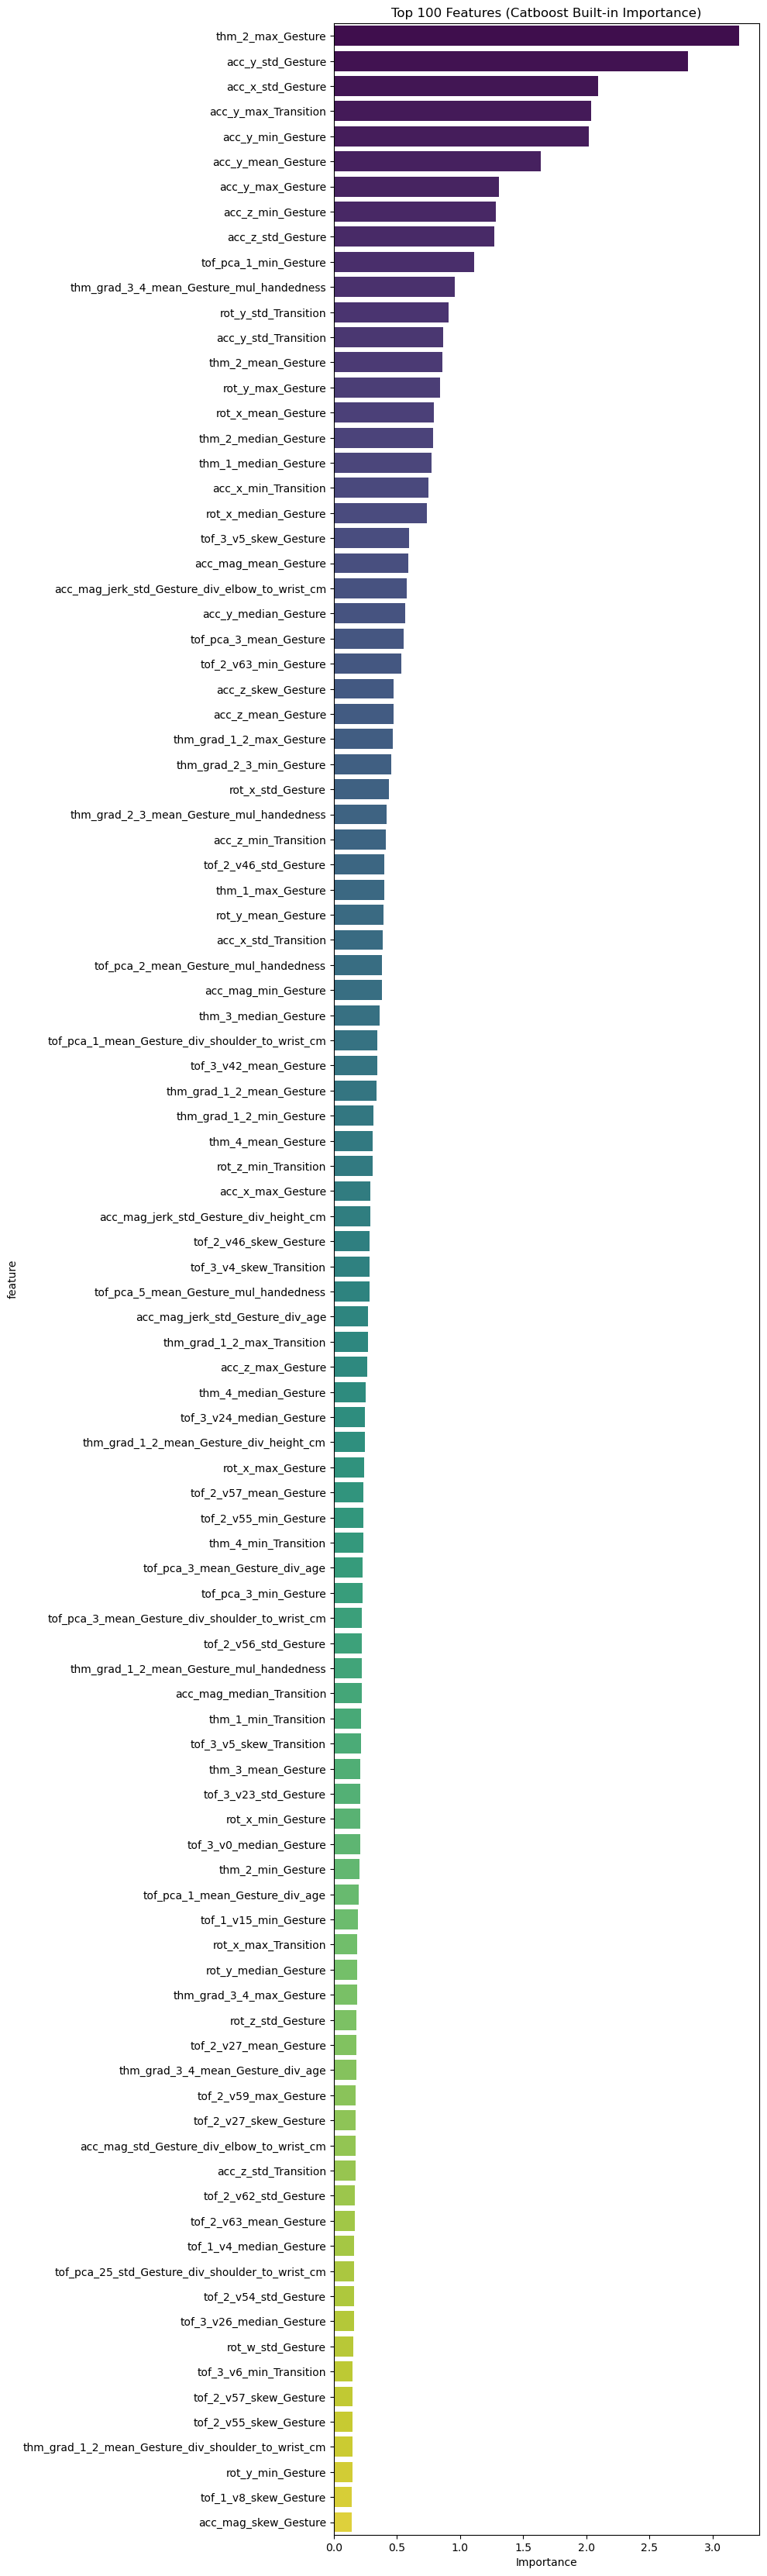

Calculating Custom Permutation Importance for CatBoost (this may take a while)...
  Baseline Score: 0.3459
  Processing feature 1/6212: acc_x_mean_Gesture
  Processing feature 51/6212: rot_x_std_Gesture
  Processing feature 101/6212: thm_2_min_Gesture
  Processing feature 151/6212: tof_1_v1_max_Gesture
  Processing feature 201/6212: tof_1_v5_median_Gesture
  Processing feature 251/6212: tof_1_v9_skew_Gesture
  Processing feature 301/6212: tof_1_v14_mean_Gesture
  Processing feature 351/6212: tof_1_v18_std_Gesture
  Processing feature 401/6212: tof_1_v22_min_Gesture
  Processing feature 451/6212: tof_1_v26_max_Gesture
  Processing feature 501/6212: tof_1_v30_median_Gesture
  Processing feature 551/6212: tof_1_v34_skew_Gesture


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7945618793a0>>
Traceback (most recent call last):
  File "/home/bac/miniforge3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


  Processing feature 601/6212: tof_1_v39_mean_Gesture


In [ ]:
# Run analysis
cb_builtin_imp, cb_perm_imp = analyze_model_importance(
    catboost_model, "Catboost", X_train, y_train, X_val, y_val, 
    inv_gesture_map, gesture_to_seq_type_map, top_n=100
)